<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 202</h1>
<h1>Network Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import networkx as nx

import scipy
from scipy.optimize import curve_fit

import tqdm as tq
from tqdm.notebook import tqdm

import watermark

import epidemik
from epidemik import EpiModel, NetworkEpiModel

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 8.32.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 6d9f1a6eb4084a40d0e306ad0ba8a2eaa55e5c85

watermark : 2.5.0
epidemik  : 0.1.2
matplotlib: 3.10.0
networkx  : 3.4.2
pandas    : 2.2.3
tqdm      : 4.67.1
numpy     : 2.2.2
scipy     : 1.15.1



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# A simple Model

Let us start with a network where eveyrone is connected to everybody else

In [4]:
np.random.seed(1234)

In [5]:
N = 300
beta = 0.05
G_full = nx.erdos_renyi_graph(N, p=1.)

And an SI model

In [7]:
SI_full = NetworkEpiModel(G_full)
SI_full.add_interaction('S', 'I', 'I', beta=beta)
SI_full

TypeError: must be real number, not str

In [8]:
print("kavg=", SI_full.kavg_)
print(SI_full.transitions.edges(data=True))

kavg= 299.0
[('S', 'I', {'agent': 'I', 'rate': 'rate'})]


We perform 100 runs

In [9]:
def simulate_runs(model, Nruns):
    values = []

    for i in tqdm(range(Nruns), total=Nruns):
        model.simulate(100, seeds={30: 'I'})
        values.append(model.I)

    values =  pd.DataFrame(values).T
    values.columns = np.arange(values.shape[1])
    
    return values

In [10]:
Nruns = 100
values_full = simulate_runs(SI_full, Nruns)

  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: '<' not supported between instances of 'float' and 'str'

And plot them. Each run has it's own stochastic path, despite the strong connectivity constraint

NameError: name 'values_full' is not defined

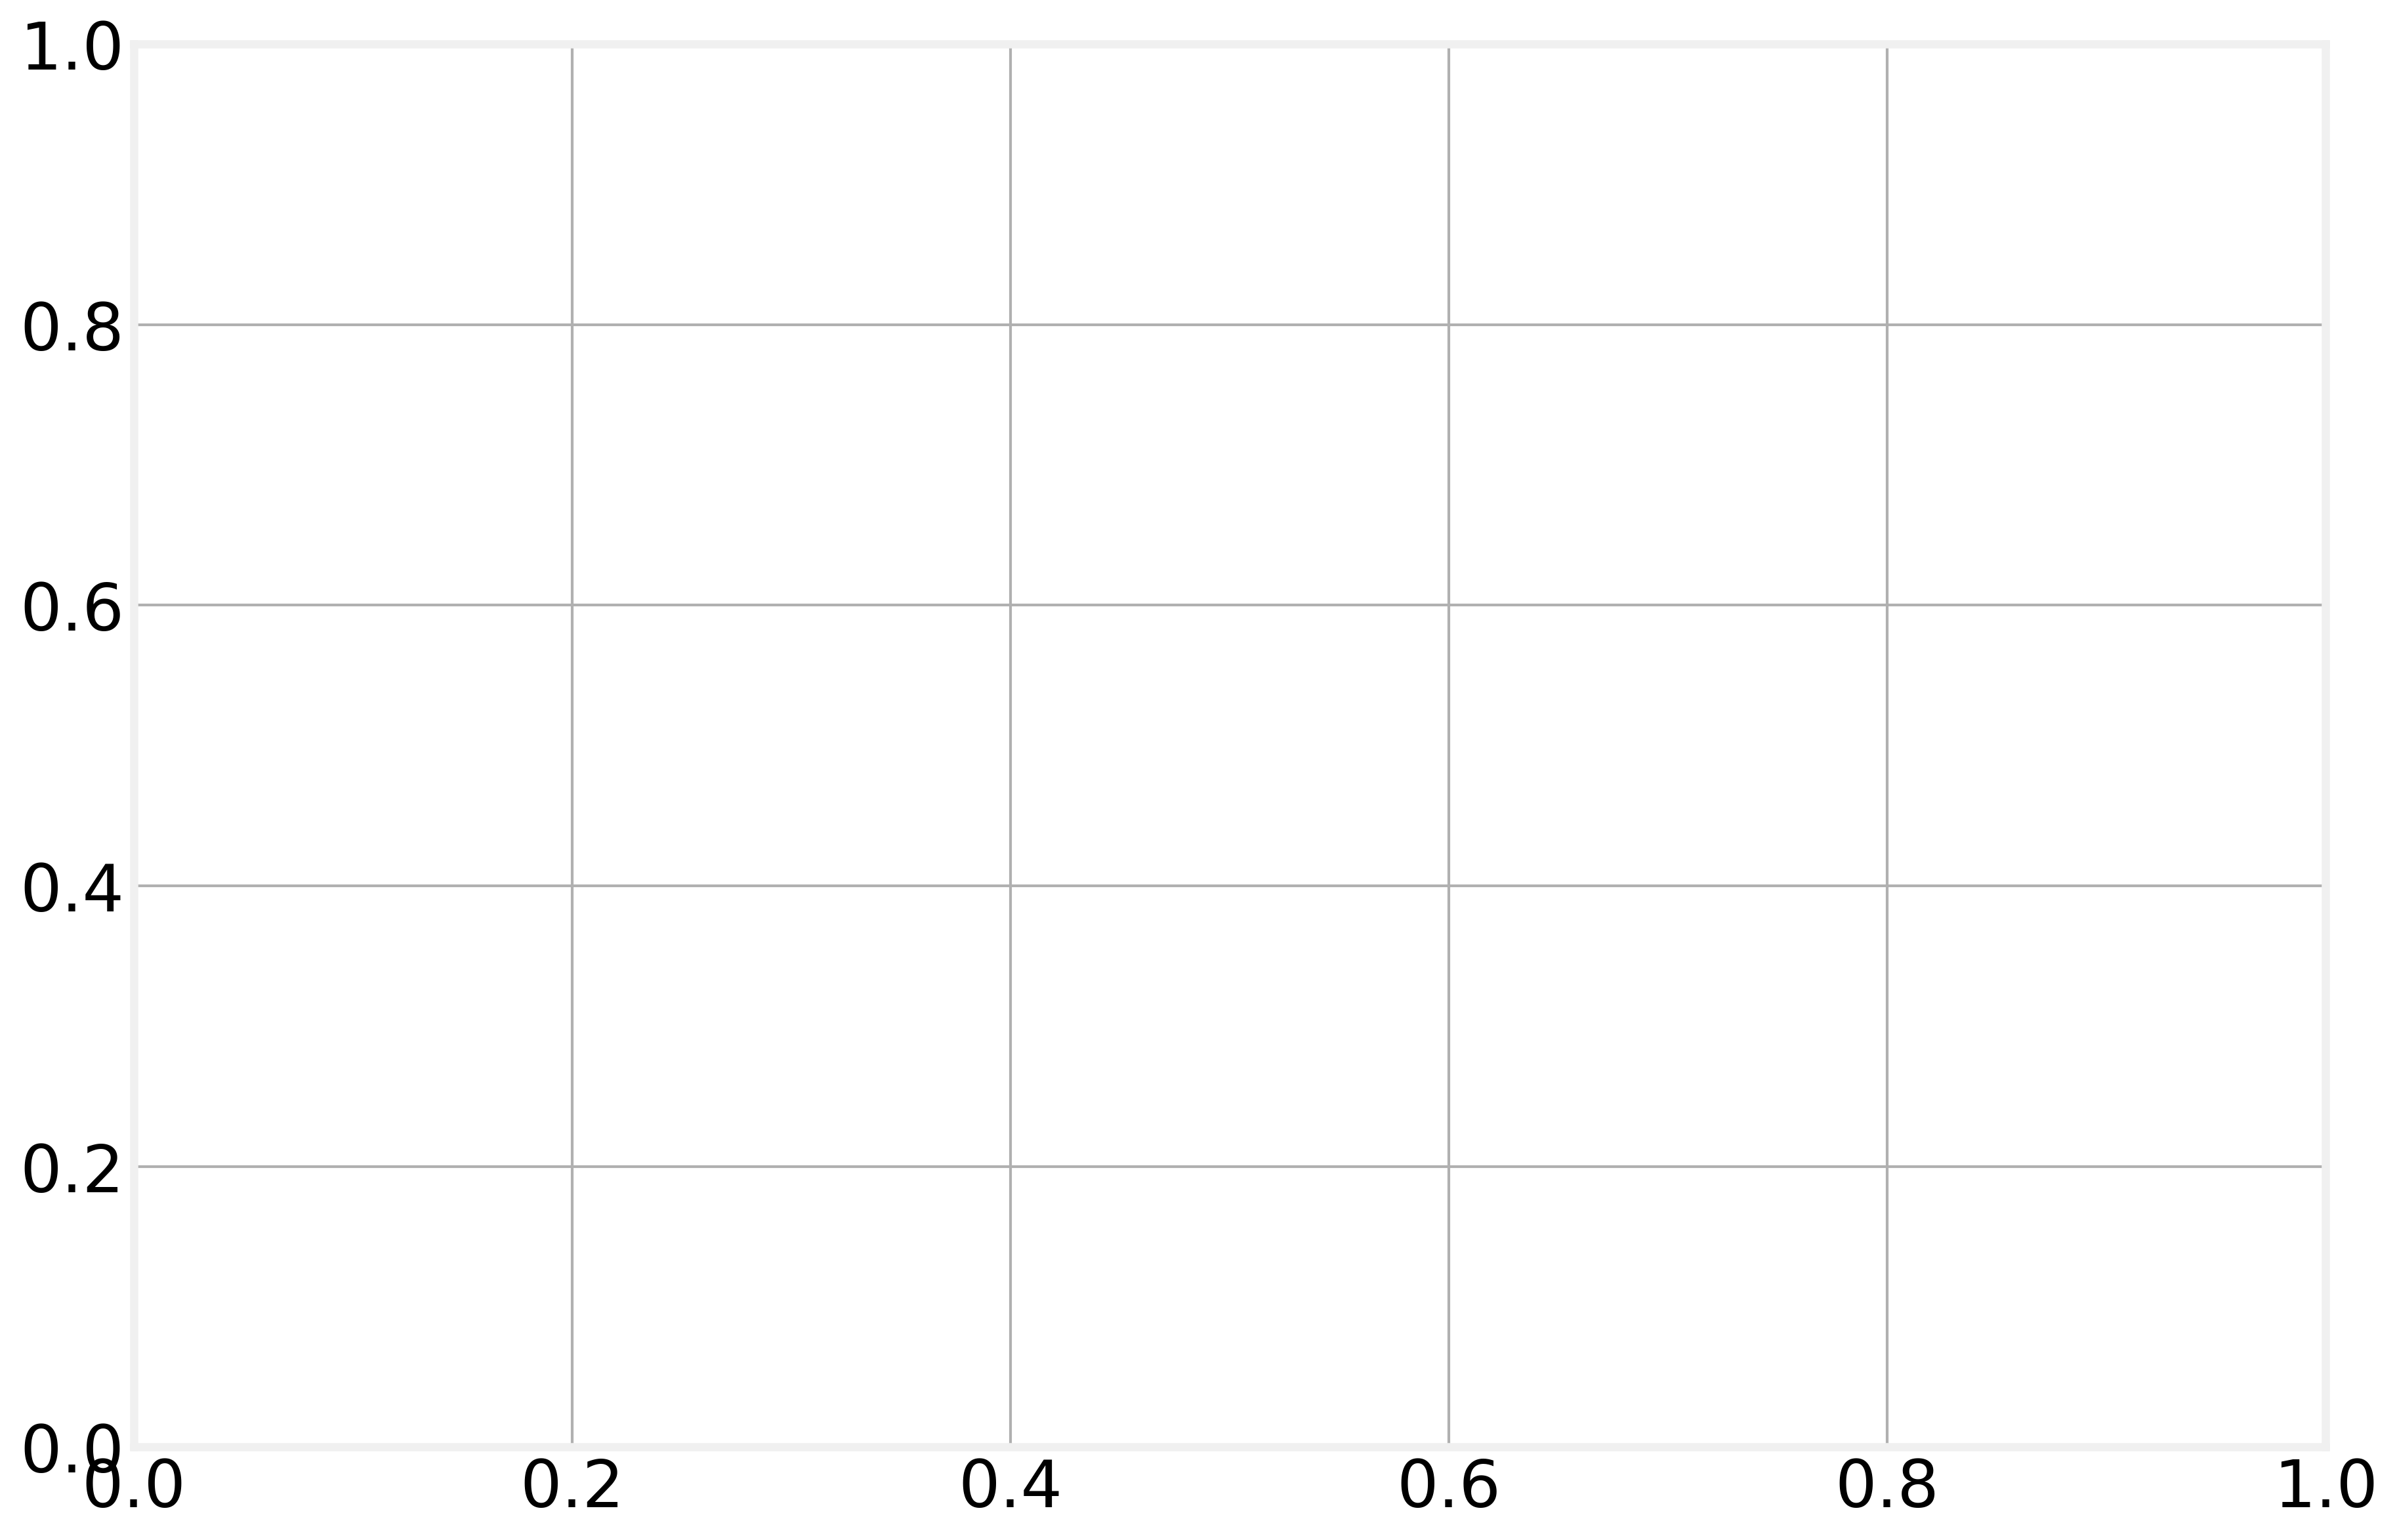

In [11]:
fig, ax = plt.subplots(1)

values_full.median(axis=1).plot(ax=ax, color=colors[0])
values_full.plot(ax=ax, color=colors[0], lw=.5)
ax.get_legend().remove()
ax.set_xlim(0, 20)
ax.legend(['Median Run', 'Individual Runs'])
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [ ]:
kmean = SI_full.kavg_
print(kmean)

We can obtain a specific average degree by setting: $$p=\frac{\langle k\rangle}{N}$$ We choose this specific value so that we match the average degree of the BA model below

In [ ]:
G_small = nx.erdos_renyi_graph(N, p=0.0198)

In [ ]:
SI_small = NetworkEpiModel(G_small)
SI_small.add_interaction('S', 'I', 'I', beta)
SI_small

In [ ]:
SI_small.kavg_

In [ ]:
values_small = simulate_runs(SI_small, Nruns)

In [ ]:
fig, ax = plt.subplots(1)

values_small.median(axis=1).plot(ax=ax, color=colors[1])
values_small.plot(ax=ax, color=colors[1], lw=.3)

ax.get_legend().remove()
ax.legend(['Median Run', 'Individual Runs'])
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [ ]:
time = np.arange(0, 100)
yt = lambda time, beta: N/(1+(N-1)*np.exp(-beta*N*time))

In [ ]:
coef, covariance = curve_fit(yt, time, values_small.median(axis=1).values)

In [ ]:
coef

In [ ]:
fig, ax = plt.subplots(1)

ax.plot(time, yt(time, *coef), color=colors[5])
values_small.median(axis=1).plot(ax=ax, color=colors[1])
values_small.plot(ax=ax, color=colors[1], lw=.3)

ax.get_legend().remove()
ax.legend(['Fit', 'Median Run', 'Individual Runs'])
ax.set_xlabel('Time')
ax.set_ylabel('Population')

We can compare the two scenarios above by plotting the median number of infected node as a function of time. Not surprisingly, the network with the smallest average connectivity is slower

In [ ]:
fig, ax = plt.subplots(1)
values_small.median(axis=1).plot(color=colors[1], ax=ax, label='ER Network')
values_full.median(axis=1).plot(color=colors[0], ax=ax, label='Full Network')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [ ]:
plt.plot(dict(G_small.degree()).values())

ax = plt.gca()
ax.set_xlabel('Node')
ax.set_ylabel('Degree')

But what about two networks with exactly the same average degree, but different topologies? Let's run a Barabasi albert model

In [ ]:
BA = nx.barabasi_albert_graph(N, m=3)

In [ ]:
SI_BA = NetworkEpiModel(BA)
SI_BA.add_interaction('S', 'I', 'I', beta)
SI_BA

The average degree is exactly the same

In [ ]:
SI_BA.kavg_

In [ ]:
values_BA = simulate_runs(SI_BA, Nruns)

In [ ]:
fig, ax = plt.subplots(1)

values_BA.median(axis=1).plot(color=colors[2], ax=ax)
values_BA.plot(ax=ax, color=colors[2], lw=.1)

ax.get_legend().remove()
ax.legend(['Median Run', 'Individual Runs'])

ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [ ]:
coef, covariance = curve_fit(yt, time, values_BA.median(axis=1).values)

In [ ]:
coef

In [ ]:
fig, ax = plt.subplots(1)

ax.plot(time, yt(time, *coef), color=colors[5])
values_BA.median(axis=1).plot(ax=ax, color=colors[2])
values_BA.plot(ax=ax, color=colors[2], lw=.3)

ax.get_legend().remove()
ax.legend(['Fit', 'Median Run', 'Individual Runs'])
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [ ]:
plt.plot(dict(BA.degree()).values())
ax = plt.gca()
ax.set_xlabel('Node')
ax.set_ylabel('Degree')

## Topology comparison

In [ ]:
fig, ax = plt.subplots(1)
values_small.median(axis=1).plot(color=colors[1], ax=ax, label='ER Network')
values_BA.median(axis=1).plot(color=colors[2], ax=ax, label='BA Network')
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [ ]:
fig, ax = plt.subplots(1)
values_full.median(axis=1).plot(color=colors[0], ax=ax, label='Full Network')
values_small.median(axis=1).plot(color=colors[1], ax=ax, label='ER Network')
values_BA.median(axis=1).plot(color=colors[2], ax=ax, label='BA Network')
ax.legend()

ax.set_xlabel('Time')
ax.set_ylabel('Population')

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>